# Machine learning
In this notebook we implement a few models to train on the df_cleaned.csv and df_cancel.csv datasets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the files.
df = pd.read_csv('df_cleaned.csv')
df_cancel = pd.read_csv('df_cancel.csv')

## Preparing our data

In order to recombine the regular flights with the cancelled flights, we need to add back the previously removed attributes which were relating to flight diversion and cancellation.

In [2]:
# Add the missing columns to the regular flights dataframe
df['CANCELLED'] = False
df['CANCELLATION_CODE'] = np.nan 
df['DIVERTED'] = False

df['CANCELLED'] = df['CANCELLED'].astype(bool)
df['DIVERTED'] = df['DIVERTED'].astype(bool)

# Combine the dataframes
combined_flights = pd.concat([df, df_cancel], ignore_index=True)


Let's take a look at the current time format:

In [3]:
print(combined_flights.iloc[39]['DEP_TIME'])

14:34


Here we format the time attributes HH:MM into minutes from midnight:

In [4]:
def time_to_minutes(time_str):
    if pd.isna(time_str):
        return None
    hours, minutes = map(int, time_str.split(":"))
    return hours * 60 + minutes

time_columns = ['CRS_DEP_TIME', 'DEP_TIME', 'WHEELS_OFF', 'WHEELS_ON', 'CRS_ARR_TIME', 'ARR_TIME']

# Combine approaches
for col in time_columns:
    combined_flights[col] = combined_flights[col].apply(time_to_minutes)

print(combined_flights.iloc[39]['DEP_TIME'])

874.0


Now we decide what attribute we will try to predict and what attributes should be available for the prediction.

For this, let's once again review the attributes list:

<font color='green'> **Green colored attributes are available before the flight**</font>
 
<font color='lightblue'> **Blue colored attributes signify attributes that we can or want to predict**   </font> 

- <font color='green'>OP_CARRIER        </font> 
- <font color='green'>OP_CARRIER_FL_NUM </font> 
- <font color='green'>ORIGIN            </font> 
- <font color='green'>DEST              </font> 
- <font color='green'>CRS_DEP_TIME      </font> 
- <font color='green'>CRS_ARR_TIME      </font> 
- <font color='green'>CRS_ELAPSED_TIME  </font> 
- <font color='green'>DISTANCE          </font> 
- <font color='green'>MONTH             </font> 
- <font color='green'>DAY               </font> 
- <font color='green'>YEAR              </font> 
- <font color='green'>DAY_OF_WEEK       </font> 
- DEP_TIME                        
- TAXI_OUT               
- WHEELS_OFF             
- WHEELS_ON              
- TAXI_IN                
- ARR_TIME               
- <font color='lightblue'>ARR_DELAY</font>
- ACTUAL_ELAPSED_TIME    
- AIR_TIME               
- CARRIER_DELAY          
- WEATHER_DELAY          
- NAS_DELAY              
- SECURITY_DELAY         
- LATE_AIRCRAFT_DELAY    
- <font color='lightblue'> CANCELLED        </font>     
- <font color='lightblue'> CANCELLATION_CODE</font>    
- <font color='lightblue'> DIVERTED         </font>       

Based on this, let's construct our featureset:

In [5]:
numeric_features = [
    'CRS_DEP_TIME', 
    'CRS_ARR_TIME', 
    'CRS_ELAPSED_TIME', 
    'DISTANCE', 
    'MONTH', 
    'DAY', 
    #'YEAR', 
    'DAY_OF_WEEK',
    'DEP_TIME'
]

categorical_features = [
    'OP_CARRIER', 
    'ORIGIN', 
    'DEST'
]

target_feature = 'ARR_DELAY'

## Model creation

Let's get started by importing all the necessary libraries for ML.

In [6]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Preprocessing function

In [8]:
# Preprocessing function
def preprocess_for_arrival_delay(combined_flights):
    global numeric_features, categorical_features, target_feature
    # Select features for prediction
    features = numeric_features + categorical_features
    
    # Create a copy of the dataframe
    df = combined_flights[features + [target_feature]].copy()
    
    # Handle missing values
    df.dropna(inplace=True)
    
    # Convert time columns to numeric minutes
    def time_to_minutes(time_value):
        if pd.isna(time_value):
            return np.nan
        
        # If it's a numeric value like 1430
        time_value = int(time_value)
        hours = time_value // 100
        minutes = time_value % 100
        return hours * 60 + minutes
    
    #df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].apply(time_to_minutes)
    #df['CRS_ARR_TIME'] = df['CRS_ARR_TIME'].apply(time_to_minutes)
    
    # Drop original time columns
    #df.drop(columns=['CRS_DEP_TIME', 'CRS_ARR_TIME'], inplace=True)
    
    # Separate features and target
    X = df.drop(target_feature, axis=1)
    y = df[target_feature]
    
    return X, y

# Example prediction
def predict_arrival_delay(model, flight_data):
    # Preprocess the input data similar to training data
    processed_data = preprocess_for_arrival_delay(flight_data)[0]
    
    # Make prediction
    predicted_delay = model.predict(processed_data)
    
    return predicted_delay

# Optional: Feature importance
def get_feature_importance(model):
    # Get feature names directly from the preprocessor
    preprocessor = model.named_steps['preprocessor']
    
    # Get numeric feature names
    numeric_transformer = preprocessor.named_transformers_['num']
    numeric_feature_names = numeric_transformer.get_feature_names_out().tolist()
    
    # Get categorical feature names
    categorical_transformer = preprocessor.named_transformers_['cat']
    categorical_feature_names = categorical_transformer.get_feature_names_out().tolist()
    
    # Combine feature names
    feature_names = numeric_feature_names + categorical_feature_names
    
    # Get feature importances
    importances = model.named_steps['regressor'].feature_importances_
    
    # Create a DataFrame of features and their importances
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    return feature_importance_df

def predict_if_flight_delayed(model, flight_data, delay_threshold=0.1):
    # Preprocess the input data similar to training data
    processed_data = preprocess_for_arrival_delay(flight_data)[0]
    
    # Make prediction
    predicted_delay = model.predict(processed_data)
    
    # Determine if the flight is delayed
    is_delayed = predicted_delay > delay_threshold
    
    return is_delayed


def are_flights_delayed_test(model, flights_count=100,combined_flights=combined_flights):
    successful = 0
    
    # Randomly select 100 rows from the DataFrame
    random_flights = combined_flights.sample(n=flights_count, random_state=42)
    
    for i, single_flight in random_flights.iterrows():
        single_flight = single_flight.to_frame().T  # Convert Series to DataFrame
        will_delay = predict_if_flight_delayed(model, single_flight)
        was_delayed = single_flight[target_feature].item() > 0
        
        if will_delay[0] == was_delayed:
            successful += 1

    return successful / flights_count



### RFR model training

Now let's create a function to train a model using Random Forest Regression.

In [9]:
def train_arrival_delay_model(combined_flights):
    global numeric_features, categorical_features
    # Preprocess data
    X, y = preprocess_for_arrival_delay(combined_flights)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Create a pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print("Model Performance:")
    print(f"Mean Absolute Error: {mae:.2f} minutes")
    print(f"Root Mean Squared Error: {rmse:.2f} minutes")
    print(f"R-squared Score: {r2:.4f}")
    
    return model

### Linear regression model training

Next let's create a function to train a model using Linear Regression.

In [10]:
from sklearn.linear_model import LinearRegression

def train_arrival_delay_model_linear_regression(combined_flights):
    global numeric_features, categorical_features
    # Preprocess data
    X, y = preprocess_for_arrival_delay(combined_flights)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Create a pipeline with Linear Regression
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print("Linear Regression Model Performance:")
    print(f"Mean Absolute Error: {mae:.2f} minutes")
    print(f"Root Mean Squared Error: {rmse:.2f} minutes")
    print(f"R-squared Score: {r2:.4f}")
    
    return model

### GBM model training

Next let's create a function for Gradient Boosting (GBM) model. 

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

def train_arrival_delay_model_gbm(combined_flights):
    global numeric_features, categorical_features
    # Preprocess data
    X, y = preprocess_for_arrival_delay(combined_flights)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Create a pipeline with GradientBoostingRegressor
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(random_state=42))
    ])
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print("Gradient Boosting Machine (GBM) Model Performance:")
    print(f"Mean Absolute Error: {mae:.2f} minutes")
    print(f"Root Mean Squared Error: {rmse:.2f} minutes")
    print(f"R-squared Score: {r2:.4f}")
    
    return model

In [12]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### LGBM model training

Next let's create a function for Light Gradient Boosting (LGBM) model. 

In [13]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def train_arrival_delay_model_lightgbm(combined_flights):
    global numeric_features, categorical_features
    # Preprocess data
    X, y = preprocess_for_arrival_delay(combined_flights)
    X.fillna(-1, inplace=True)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a preprocessor
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    # Create a pipeline with LightGBM using fixed hyperparameters
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', lgb.LGBMRegressor(
            num_leaves=100,
            n_estimators=650,
            max_depth=75,
            learning_rate=0.01,
            colsample_bytree=0.75,
            verbosity=-1,
            random_state=42
        ))
    ])

    # Train the pipeline
    model_pipeline.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model_pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("\nLightGBM Model Performance with Fixed Hyperparameters:")
    print(f"Mean Absolute Error: {mae:.2f} minutes")
    print(f"Root Mean Squared Error: {rmse:.2f} minutes")
    print(f"R-squared Score: {r2:.4f}")

    return model_pipeline


## Model testing / results

Now let's train and test the models.
We will not be using the whole dataset, but rather a small subset of it using `DataFrame.sample(frac=0.x)`.

In [14]:
dataset = combined_flights

chosen_flight = 15
single_flight = dataset.iloc[[chosen_flight]]
print(f"Actual delay : {single_flight[target_feature]}")

# Take a sample
combined_flights_2 = dataset.sample(frac=0.0015, random_state=42)

## RFR prediction.
arrival_delay_model = train_arrival_delay_model(combined_flights_2)
predicted_delay = predict_arrival_delay(arrival_delay_model, single_flight)
print("Predicted Delay (RFR):", predicted_delay)

## LINEAR REGRESSION prediction.
print("---")
arrival_delay_model_2 = train_arrival_delay_model_linear_regression(combined_flights_2)
predicted_delay = predict_arrival_delay(arrival_delay_model_2, single_flight)
print("Predicted Delay (LR):", predicted_delay)


## GBM prediction.
print("---")
arrival_delay_model_3 = train_arrival_delay_model_gbm(combined_flights_2)
predicted_delay = predict_arrival_delay(arrival_delay_model_3, single_flight)
print("Predicted Delay (GBM):", predicted_delay)


## lightGBM prediction.
arrival_delay_model_4 = train_arrival_delay_model_lightgbm(combined_flights_2)
predicted_delay = predict_arrival_delay(arrival_delay_model_4, single_flight)
print("Predicted Delay (lightGBM):", predicted_delay)


# PREDICTIONS IF FLIGHTS WERE DELAYED OR NOT.
rfr_pred = are_flights_delayed_test(arrival_delay_model)
linear_pred = are_flights_delayed_test(arrival_delay_model_2)
gbm_pred = are_flights_delayed_test(arrival_delay_model_3)
lightgbm_pred = are_flights_delayed_test(arrival_delay_model_4)

print("RFR prediction if flights are delayed:", rfr_pred)
print("Linear Regression prediction if flights are delayed:", linear_pred)
print("GBM prediction if flights are delayed:", gbm_pred)
print("LightGBM prediction if flights are delayed:", lightgbm_pred)

Actual delay : 15    7.0
Name: ARR_DELAY, dtype: float64
Model Performance:
Mean Absolute Error: 10.14 minutes
Root Mean Squared Error: 15.26 minutes
R-squared Score: 0.8163
Predicted Delay (RFR): [-3.38]
---
Linear Regression Model Performance:
Mean Absolute Error: 19.88 minutes
Root Mean Squared Error: 39.06 minutes
R-squared Score: -0.2033
Predicted Delay (LR): [25.41118719]
---
Gradient Boosting Machine (GBM) Model Performance:
Mean Absolute Error: 13.05 minutes
Root Mean Squared Error: 19.74 minutes
R-squared Score: 0.6926
Predicted Delay (GBM): [-2.72941732]

LightGBM Model Performance with Fixed Hyperparameters:
Mean Absolute Error: 10.50 minutes
Root Mean Squared Error: 16.53 minutes
R-squared Score: 0.7844
Predicted Delay (lightGBM): [-5.32894215]
RFR prediction if flights are delayed: 0.93
Linear Regression prediction if flights are delayed: 0.68
GBM prediction if flights are delayed: 0.74
LightGBM prediction if flights are delayed: 0.84


### Predicting whether a flight is delayed

Let's visualize the models' performance on predicting if a flight will be delayed or not.

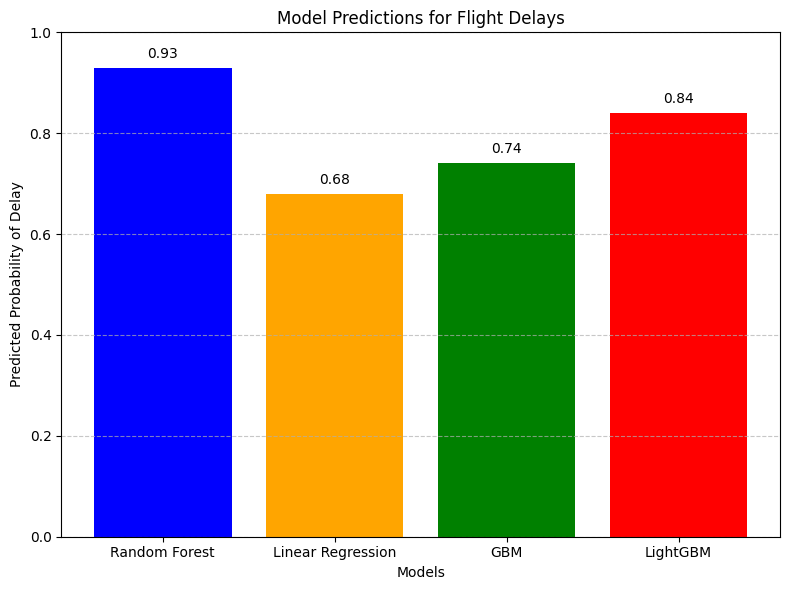

In [15]:
# Model names and corresponding predictions
model_names = ['Random Forest', 'Linear Regression', 'GBM', 'LightGBM']
predictions = [rfr_pred, linear_pred, gbm_pred, lightgbm_pred]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(model_names, predictions, color=['blue', 'orange', 'green', 'red'])
plt.title('Model Predictions for Flight Delays')
plt.ylabel('Predicted Probability of Delay')
plt.xlabel('Models')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with values
for i, value in enumerate(predictions):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("ModelPredictionsForFlightDelays.pdf")
plt.show()

### Predicting the length of delay (regression)

Now let's create a plot that shows how well do the models predict how long a flight has been delayed for.

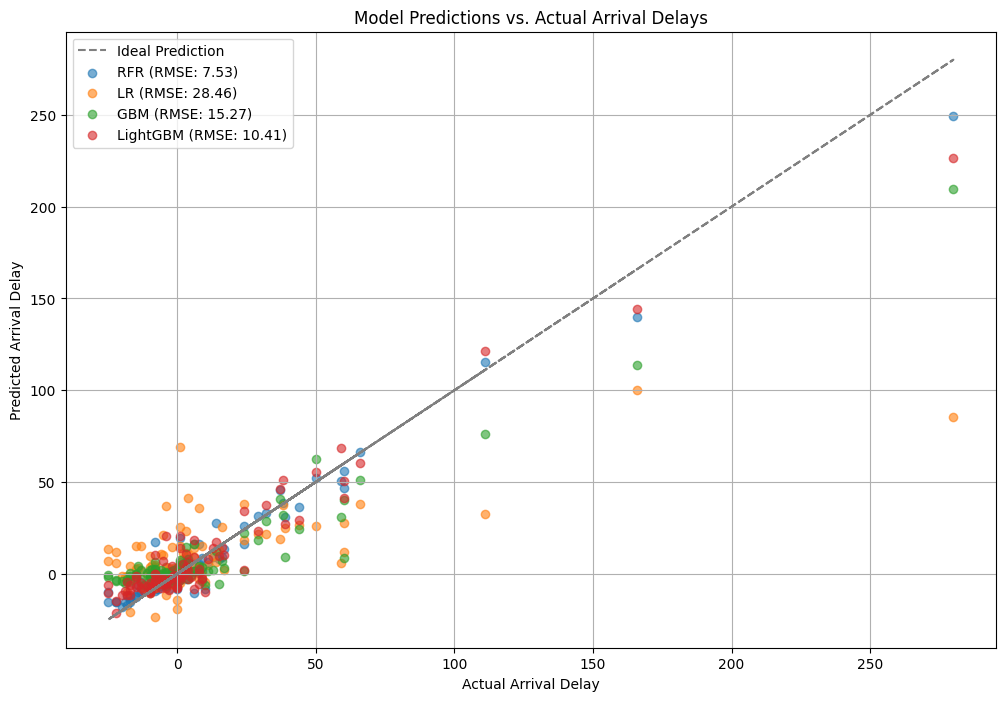

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

# Randomly sample 100 flights for testing
test_flights = combined_flights.sample(n=100, random_state=42)

# Assuming actual delays are in a column named 'arrival_delay'
actual_delays = test_flights[target_feature]

# Generate predictions for each model on the sampled test set
predicted_delays_rfr = predict_arrival_delay(arrival_delay_model, test_flights)
predicted_delays_lr = predict_arrival_delay(arrival_delay_model_2, test_flights)
predicted_delays_gbm = predict_arrival_delay(arrival_delay_model_3, test_flights)
predicted_delays_lgbm = predict_arrival_delay(arrival_delay_model_4, test_flights)

# Calculate RMSE for each model
rmse_rfr = root_mean_squared_error(actual_delays, predicted_delays_rfr)
rmse_lr = root_mean_squared_error(actual_delays, predicted_delays_lr)
rmse_gbm = root_mean_squared_error(actual_delays, predicted_delays_gbm)
rmse_lgbm = root_mean_squared_error(actual_delays, predicted_delays_lgbm)

# Create a scatter plot to compare predictions with actual delays
plt.figure(figsize=(12, 8))
plt.plot(actual_delays, actual_delays, label='Ideal Prediction', color='gray', linestyle='--')

plt.scatter(actual_delays, predicted_delays_rfr, label=f'RFR (RMSE: {rmse_rfr:.2f})', alpha=0.6)
plt.scatter(actual_delays, predicted_delays_lr, label=f'LR (RMSE: {rmse_lr:.2f})', alpha=0.6)
plt.scatter(actual_delays, predicted_delays_gbm, label=f'GBM (RMSE: {rmse_gbm:.2f})', alpha=0.6)
plt.scatter(actual_delays, predicted_delays_lgbm, label=f'LightGBM (RMSE: {rmse_lgbm:.2f})', alpha=0.6)

# Customize the plot
plt.title('Model Predictions vs. Actual Arrival Delays')
plt.xlabel('Actual Arrival Delay')
plt.ylabel('Predicted Arrival Delay')
plt.legend()
plt.grid()
plt.show()